# OCR de Imagem com Modelo Treinado

Este notebook realiza OCR na imagem [ocr_test_image.png](../data/raw/ocr_test_image.png) utilizando o modelo treinado [modelo_ocr_simbolos.keras](../data/processed/modelo_ocr_simbolos.keras).

In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import json
from pathlib import Path
import cv2

2025-10-18 14:59:22.882024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 14:59:22.919946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 14:59:27.166806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def find_project_root(markers=("pyproject.toml", ".git")) -> Path:
    """
    Descobre a raiz do projeto subindo diretórios até encontrar um marcador.
    """
    p = Path.cwd().resolve()
    for parent in [p, *p.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    return p

ROOT = find_project_root()
print(f"Raiz do projeto: {ROOT}")

Raiz do projeto: /mnt/x/01-projetos/11-work/11.32-doutorado/DL/projeto_elis


In [3]:
# Configurações
DATA_DIR = ROOT / "data"
MODEL_PATH = DATA_DIR / "processed" / "modelo_ocr_simbolos.keras"
IMAGE_PATH = DATA_DIR / "raw" / "ocr_test_image.png"
CLASS_NAMES_PATH = DATA_DIR / "raw" / "class_names.json"

IMG_HEIGHT = 64
IMG_WIDTH = 64

In [4]:
# Carrega o modelo treinado
print("Carregando modelo...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✓ Modelo carregado com sucesso!")
model.summary()

Carregando modelo...


I0000 00:00:1760810369.524114   67184 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


✓ Modelo carregado com sucesso!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 149)            │        38,293 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,685,121 (25.50 MB)

 Trainable params: 2,228,373 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,456,748 (17.00 MB)

In [5]:
# Carrega os nomes das classes
with open(CLASS_NAMES_PATH, 'r', encoding='utf-8') as f:
    class_names = json.load(f)
print(f"✓ {len(class_names)} classes carregadas")
print(f"Exemplos: {class_names[:5]}")

✓ 146 classes carregadas
Exemplos: ['U+0020', 'U+0021', 'U+0022', 'U+0023', 'U+0024']


In [6]:
def unicode_to_char(unicode_str: str) -> str:
    """
    Converte 'U+XXXX' para o caractere correspondente.
    Exemplo: 'U+0041' -> 'A'
    """
    try:
        codepoint = int(unicode_str.replace('U+', ''), 16)
        return chr(codepoint)
    except:
        return '?'

Carregando imagem: /mnt/x/01-projetos/11-work/11.32-doutorado/DL/projeto_elis/data/raw/ocr_test_image.png


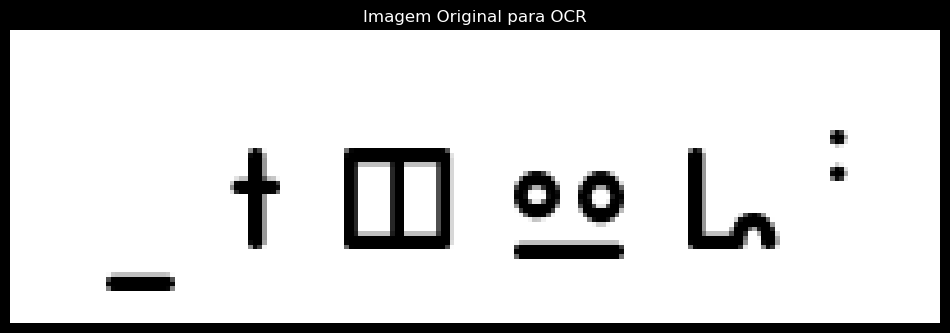

Dimensões: (203, 64)
Modo: L


In [7]:
# Carrega e exibe a imagem original
print(f"Carregando imagem: {IMAGE_PATH}")
original_image = Image.open(IMAGE_PATH)

plt.figure(figsize=(12, 4))
plt.imshow(original_image, cmap='gray')
plt.title('Imagem Original para OCR')
plt.axis('off')
plt.show()

print(f"Dimensões: {original_image.size}")
print(f"Modo: {original_image.mode}")

In [8]:
def preprocess_image_for_ocr(image: Image.Image) -> np.ndarray:
    """
    Pré-processa a imagem para OCR:
    - Converte para escala de cinza
    - Aplica threshold para binarização
    - Inverte cores se necessário (fundo branco, texto preto)
    """
    # Converte para escala de cinza
    if image.mode != 'L':
        image = image.convert('L')

    # Converte para numpy array
    img_array = np.array(image)

    # Aplica threshold adaptativo para melhor binarização
    img_binary = cv2.adaptiveThreshold(
        img_array, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Verifica se precisa inverter (modelo espera fundo branco, texto preto)
    # Se a média é baixa, a imagem está com fundo escuro
    if np.mean(img_binary) < 127:
        img_binary = 255 - img_binary

    return img_binary

Pré-processando imagem...


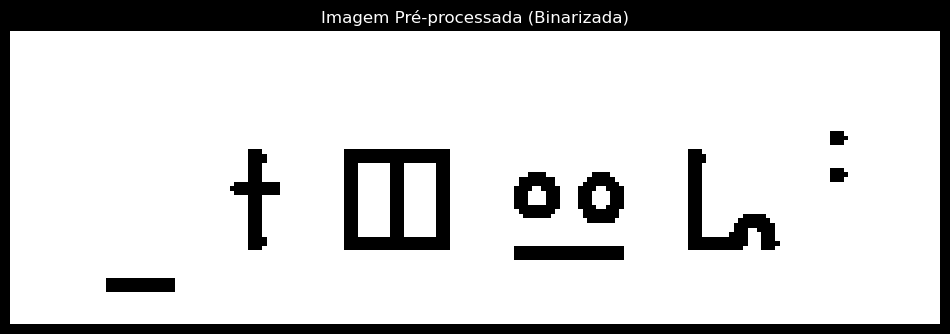

In [9]:
# Pré-processa a imagem
print("Pré-processando imagem...")
processed_image = preprocess_image_for_ocr(original_image)

plt.figure(figsize=(12, 4))
plt.imshow(processed_image, cmap='gray')
plt.title('Imagem Pré-processada (Binarizada)')
plt.axis('off')
plt.show()

In [10]:
def segment_characters_with_grouping(image_array: np.ndarray,
                                     max_gap: int = 15,
                                     min_component_area: int = 10) -> list:
    """
    Segmenta caracteres compostos por múltiplos contornos próximos.
    Similar ao OCR de Hangul onde um símbolo tem componentes separados.

    Args:
        image_array: Imagem binarizada
        max_gap: Distância horizontal máxima entre contornos do mesmo símbolo
        min_component_area: Área mínima para considerar um contorno válido

    Returns:
        Lista de (bbox_composto, imagem_segmentada, contornos_componentes)
    """
    # 1. Encontra todos os contornos
    contours, _ = cv2.findContours(
        255 - image_array,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # 2. Extrai bounding boxes e filtra ruído
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area >= min_component_area:
            boxes.append({
                'x': x, 'y': y, 'w': w, 'h': h,
                'x_center': x + w // 2,
                'x_end': x + w,
                'contour': contour
            })

    # 3. Ordena boxes da esquerda para direita
    boxes = sorted(boxes, key=lambda b: b['x'])

    if not boxes:
        return []

    # 4. Agrupa contornos próximos em símbolos compostos
    symbol_groups = []
    current_group = [boxes[0]]

    for i in range(1, len(boxes)):
        prev_box = current_group[-1]
        curr_box = boxes[i]

        # Calcula gap horizontal entre o fim do anterior e início do atual
        gap = curr_box['x'] - prev_box['x_end']

        # Se gap é pequeno, agrupa no mesmo símbolo
        if gap <= max_gap:
            current_group.append(curr_box)
        else:
            # Gap grande: novo símbolo
            symbol_groups.append(current_group)
            current_group = [curr_box]

    # Adiciona último grupo
    symbol_groups.append(current_group)

    # 5. Cria bounding box composto para cada grupo
    segmented_symbols = []

    for group in symbol_groups:
        # Calcula bbox que engloba todos os componentes
        x_min = min(box['x'] for box in group)
        y_min = min(box['y'] for box in group)
        x_max = max(box['x'] + box['w'] for box in group)
        y_max = max(box['y'] + box['h'] for box in group)

        # Adiciona padding
        padding = 5
        x1 = max(0, x_min - padding)
        y1 = max(0, y_min - padding)
        x2 = min(image_array.shape[1], x_max + padding)
        y2 = min(image_array.shape[0], y_max + padding)

        # Extrai região da imagem
        symbol_img = image_array[y1:y2, x1:x2]

        # Informações do símbolo composto
        bbox = (x1, y1, x2 - x1, y2 - y1)
        component_count = len(group)

        segmented_symbols.append({
            'bbox': bbox,
            'image': symbol_img,
            'components': component_count,
            'component_boxes': [(b['x'], b['y'], b['w'], b['h']) for b in group]
        })

    return segmented_symbols


def analyze_spacing(image_array: np.ndarray) -> dict:
    """
    Analisa o espaçamento entre contornos para sugerir max_gap ideal.
    """
    contours, _ = cv2.findContours(
        255 - image_array,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > 10:
            boxes.append({'x': x, 'w': w, 'x_end': x + w})

    boxes = sorted(boxes, key=lambda b: b['x'])

    # Calcula gaps
    gaps = []
    for i in range(1, len(boxes)):
        gap = boxes[i]['x'] - boxes[i-1]['x_end']
        gaps.append(gap)

    if not gaps:
        return {'gaps': [], 'suggested_max_gap': 15}

    gaps = np.array(gaps)

    # Estatísticas
    stats = {
        'gaps': gaps.tolist(),
        'mean': float(np.mean(gaps)),
        'median': float(np.median(gaps)),
        'std': float(np.std(gaps)),
        'min': float(np.min(gaps)),
        'max': float(np.max(gaps)),
        'suggested_max_gap': int(np.percentile(gaps, 25))  # 25º percentil
    }

    return stats

Analisando espaçamento entre contornos...

Estatísticas de gaps:
  Média: 5.1 pixels
  Mediana: 11.5 pixels
  Desvio padrão: 12.5 pixels
  Min/Max: -24 / 14 pixels
  ✓ max_gap sugerido: 2 pixels


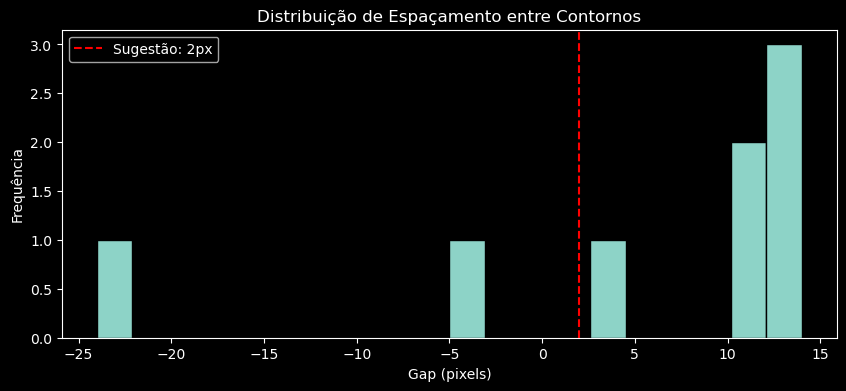

In [11]:
# Célula para análise de espaçamento (execute primeiro para calibrar)
print("Analisando espaçamento entre contornos...")
spacing_stats = analyze_spacing(processed_image)

print(f"\nEstatísticas de gaps:")
print(f"  Média: {spacing_stats['mean']:.1f} pixels")
print(f"  Mediana: {spacing_stats['median']:.1f} pixels")
print(f"  Desvio padrão: {spacing_stats['std']:.1f} pixels")
print(f"  Min/Max: {spacing_stats['min']:.0f} / {spacing_stats['max']:.0f} pixels")
print(f"  ✓ max_gap sugerido: {spacing_stats['suggested_max_gap']} pixels")

# Visualiza distribuição de gaps
plt.figure(figsize=(10, 4))
plt.hist(spacing_stats['gaps'], bins=20, edgecolor='black')
plt.axvline(spacing_stats['suggested_max_gap'], color='r', linestyle='--',
            label=f"Sugestão: {spacing_stats['suggested_max_gap']}px")
plt.xlabel('Gap (pixels)')
plt.ylabel('Frequência')
plt.title('Distribuição de Espaçamento entre Contornos')
plt.legend()
plt.show()


Segmentando símbolos compostos...
✓ 7 símbolos detectados


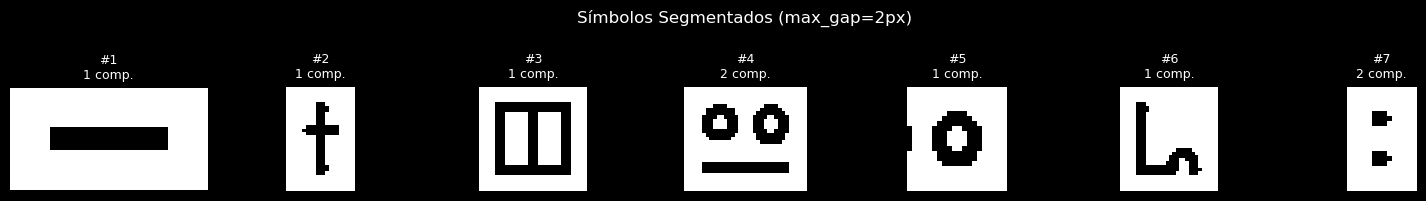


Componentes por símbolo:
  Média: 1.3
  Min/Max: 1 / 2


In [12]:
# Célula para segmentação com agrupamento
print("\nSegmentando símbolos compostos...")

# Use o max_gap sugerido ou ajuste manualmente
MAX_GAP = spacing_stats['suggested_max_gap']  # ou um valor fixo como 15

segmented_symbols = segment_characters_with_grouping(
    processed_image,
    max_gap=MAX_GAP,
    min_component_area=10
)

print(f"✓ {len(segmented_symbols)} símbolos detectados")

# Visualiza símbolos com informação de componentes
if len(segmented_symbols) > 0:
    n_symbols = len(segmented_symbols)
    cols = min(10, n_symbols)
    rows = (n_symbols + cols - 1) // cols

    plt.figure(figsize=(15, 2 * rows))
    for i, symbol in enumerate(segmented_symbols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(symbol['image'], cmap='gray')
        plt.title(f"#{i+1}\n{symbol['components']} comp.", fontsize=9)
        plt.axis('off')
    plt.suptitle(f'Símbolos Segmentados (max_gap={MAX_GAP}px)')
    plt.tight_layout()
    plt.show()

    # Estatísticas
    comp_counts = [s['components'] for s in segmented_symbols]
    print(f"\nComponentes por símbolo:")
    print(f"  Média: {np.mean(comp_counts):.1f}")
    print(f"  Min/Max: {min(comp_counts)} / {max(comp_counts)}")
else:
    print("⚠ Nenhum símbolo detectado!")

In [14]:
def prepare_char_for_prediction(char_image: np.ndarray) -> np.ndarray:
    """
    Prepara um caractere segmentado para predição:
    - Redimensiona para 64x64
    - Centraliza o caractere
    - Adiciona dimensões do batch e canal
    """
    # Cria canvas quadrado branco
    size = max(char_image.shape)
    canvas = np.ones((size, size), dtype=np.uint8) * 255

    # Centraliza o caractere
    y_offset = (size - char_image.shape[0]) // 2
    x_offset = (size - char_image.shape[1]) // 2
    canvas[y_offset:y_offset+char_image.shape[0],
           x_offset:x_offset+char_image.shape[1]] = char_image

    # Redimensiona para 64x64
    resized = cv2.resize(canvas, (IMG_WIDTH, IMG_HEIGHT),
                        interpolation=cv2.INTER_LANCZOS4)

    # Adiciona dimensões: (1, 64, 64, 1)
    # IMPORTANTE: NÃO normalizar aqui - o modelo tem Rescaling(1./255) interno
    prepared = resized.reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)

    return prepared

In [ ]:
# Célula para OCR com os símbolos agrupados
print("\nRealizando OCR dos símbolos compostos...")
results = []

for i, symbol_data in enumerate(segmented_symbols):
    bbox = symbol_data['bbox']
    char_img = symbol_data['image']

    # Prepara para predição
    input_array = prepare_char_for_prediction(char_img)

    # Predição
    predictions = model.predict(input_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]

    # Converte para caractere
    unicode_class = class_names[predicted_idx]
    character = unicode_to_char(unicode_class)

    results.append({
        'index': i,
        'bbox': bbox,
        'unicode': unicode_class,
        'character': character,
        'confidence': confidence,
        'components': symbol_data['components'],
        'component_boxes': symbol_data['component_boxes'],
        'image': char_img
    })

    comp_info = f" ({symbol_data['components']} componentes)" if symbol_data['components'] > 1 else ""
    print(f"Símbolo {i+1}: '{character}' ({unicode_class}){comp_info} - Confiança: {confidence:.4f}")

recognized_text = ''.join([r['character'] for r in results])
print(f"\n{'='*60}")
print(f"TEXTO RECONHECIDO: {recognized_text}")
print(f"{'='*60}")



Realizando OCR dos símbolos compostos...


2025-10-18 15:00:27.828138: I external/local_xla/xla/service/service.cc:163] XLA service 0x734c34004cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-18 15:00:27.828168: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-18 15:00:27.854216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-18 15:00:27.916481: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
I0000 00:00:1760810429.144621   67323 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Símbolo 1: 't' (U+0074) - Confiança: 0.9739
Símbolo 2: 'h' (U+0068) - Confiança: 1.0000
Símbolo 3: 'z' (U+007A) - Confiança: 1.0000
Símbolo 4: 'D' (U+0044) (2 componentes) - Confiança: 1.0000
Símbolo 5: '4' (U+0034) - Confiança: 0.9827
Símbolo 6: 'Ì' (U+00CC) - Confiança: 1.0000
Símbolo 7: 'k' (U+006B) (2 componentes) - Confiança: 0.8258

TEXTO RECONHECIDO: thzD4Ìk


#### Texto a ser reconhecido na imagem:
```
- Palavra "Rosa" em ELiS
- U+0074, U+0068, U+007A, U+0044, U+00CC, U+00B0 em Unicode
- "thzDÌm" em ASCII
```